# A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems
This is the code for the paper entitled "**A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems**" accepted in *IEEE Transactions on Industrial Informatics* (IF: 11.648).  <br>
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  <br>
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang and A. Shami, "A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems," IEEE Transactions on Industrial Informatics, pp. 1-10, 2022.

# 1. Load Data and Define Functions

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

#import river, an online learning library
from river import feature_selection
from river import stats
from river import imblearn
from river import preprocessing
from river import evaluate
from river import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Dataset 2: IoTID20
A subset of the IoT network traffic data randomly sampled from the [IoTID20 dataset](https://sites.google.com/view/iot-network-intrusion-dataset/home).   

IoTID20 dataset was created by using normal and attack virtual machines as network platforms, simulating IoT services with the node-red tool, and extracting features with the Information Security Center of Excellence (ISCX) flow meter program. A typical smart home environment was established for generating this dataset using five IoT devices or services: a smart fridge, a smart thermostat, motion-activated lights, a weather station, and a remotely-activated garage door. Thus, the traffic data samples of normal and abnormal IoT devices are collected in Pcap files.

## Read the sampled IoTID20 dataset

In [3]:
df = pd.read_csv("Data/IoT_2020_b_0.01.csv")

In [4]:
df

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Timestamp,Flow_Duration,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Bwd_Pkt_Len_Max,...,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Std,FIN_Flag_Cnt,Pkt_Size_Avg,Init_Bwd_Win_Byts,Idle_Mean,Idle_Max,Idle_Min,Label
0,12708,25886,53190,200,9020,3760,124,0.0,2776.0,1388.0,...,0.00,16129.03,0.00,0,2082.0,1869,124.00,124.0,124.0,1
1,60,25883,60357,110,7760,3649,46189,2528.0,0.0,0.0,...,43.30,43.30,698.97,0,632.0,126,15396.33,40225.0,1910.0,1
2,12695,25883,9020,203,52739,2261,73,1388.0,1388.0,1388.0,...,13698.63,13698.63,0.00,0,2082.0,1869,73.00,73.0,73.0,1
3,12690,25886,52717,200,9020,1963,149,0.0,0.0,0.0,...,13422.82,6711.41,0.00,0,0.0,32679,74.50,75.0,74.0,1
4,12690,25886,52717,200,9020,1905,83,0.0,0.0,0.0,...,12048.19,12048.19,0.00,0,0.0,32422,83.00,83.0,83.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,12659,25886,10125,200,9020,1057,70,0.0,2776.0,1388.0,...,0.00,28571.43,0.00,0,2082.0,1869,70.00,70.0,70.0,1
6248,13708,25883,60158,233,8899,3264,40,128.0,32.0,32.0,...,100000.00,25000.00,0.00,0,38.4,-1,10.00,21.0,5.0,1
6249,7655,15614,8487,200,554,3697,1283,0.0,0.0,0.0,...,0.00,1558.85,0.00,0,0.0,14600,1283.00,1283.0,1283.0,1
6250,62696,25889,64783,233,9988,3192,222,96.0,32.0,32.0,...,13513.51,4504.50,0.00,0,40.0,-1,74.00,206.0,8.0,1


## Train-test split
10% training set, and 90% test set

In [5]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

## Basic Adaptive Learning - Define Functions

In [6]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN,EDDM,HDDM_A,HDDM_W,KSWIN,PageHinkley

In [7]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = EDDM()
    
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        
        #drift_detection part
        val = 0
        if yi != y_pred:
            val = 1 
        in_drift, in_warning = eddm.update(float(val))
        if in_drift:
            print(f"Change detected at index {i}")
        
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [8]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Change detected at index 785
Change detected at index 3369
Accuracy: 97.89%
Precision: 98.27%
Recall: 99.51%
F1-score: 98.89%
Wall time: 5.81 s


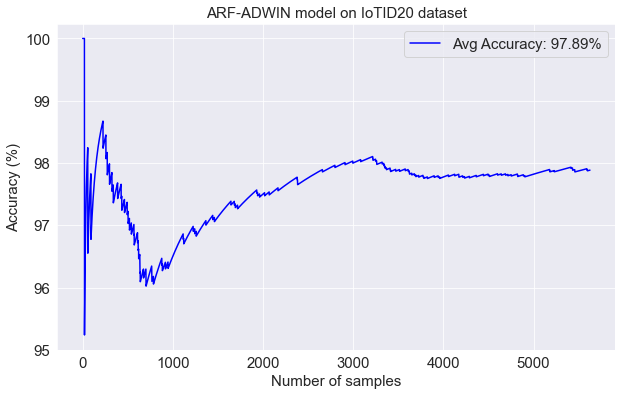

In [9]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

# 2. Dynamic Data Pre-Processing

The dynamic data pre-processing part focuses on data balancing and data normalization. Examples of using them are given below.   
* Data balancing methods include Dynamic Random Under-Sampling (DRUS) and Dynamic Random Over-Sampling (DROS);  
* Data normalization methods include dynamic min-max and Z-score scalers.  <br>


Change detected at index 406
Accuracy: 96.28999999999999%
Precision: 97.98%
Recall: 98.08%
F1-score: 98.03%
Wall time: 4.45 s


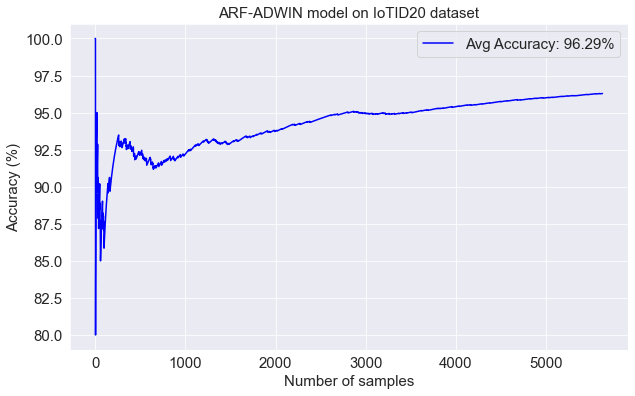

In [28]:
%%time
# Min-max normalization & random under-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomUnderSampler( (
                                    preprocessing.MinMaxScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.1, 1: 0.9}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 1/9. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 519
Change detected at index 1451
Change detected at index 3160
Change detected at index 4684
Accuracy: 97.48%
Precision: 98.28%
Recall: 99.06%
F1-score: 98.67%
Wall time: 4.77 s


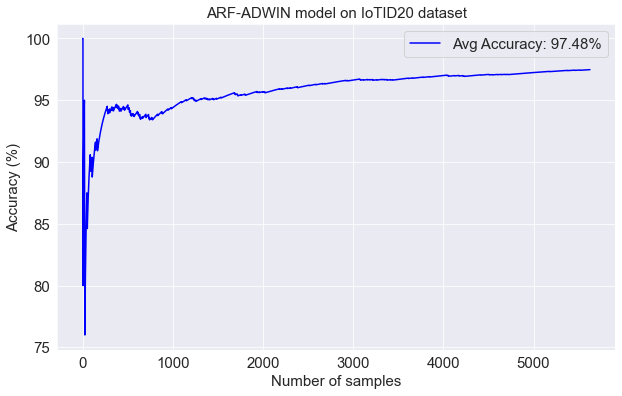

In [29]:
%%time
# Z-score normalization & random under-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomUnderSampler( (
                                    preprocessing.StandardScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.1, 1: 0.9}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 1/9. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 441
Change detected at index 1998
Accuracy: 97.96000000000001%
Precision: 98.22999999999999%
Recall: 99.62%
F1-score: 98.92%
Wall time: 6.5 s


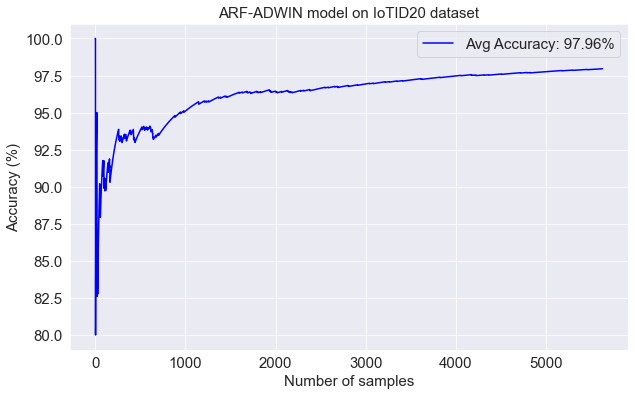

In [30]:
%%time
# Min-max normalization & random over-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomOverSampler( (
                                    preprocessing.MinMaxScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.1, 1: 0.9}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 1/9. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 675
Change detected at index 1462
Change detected at index 1998
Accuracy: 96.98%
Precision: 97.66%
Recall: 99.17%
F1-score: 98.41%
Wall time: 7.06 s


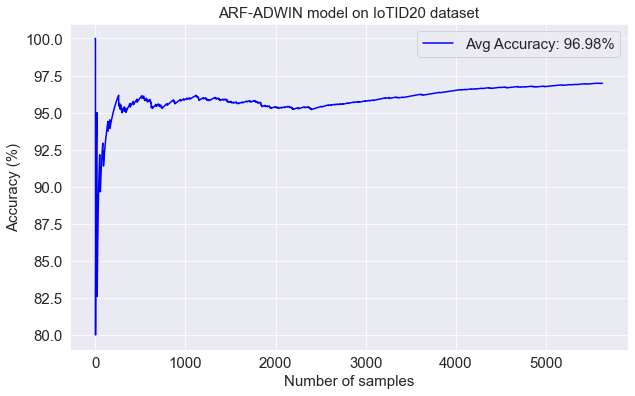

In [31]:
%%time
# Z-score normalization & random over-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomOverSampler( (
                                    preprocessing.StandardScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.1, 1: 0.9}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 1/9. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

# 3. Model Learning

## Base Model Learning for Comparison Purposes
State-of-the-art online learning models:
* Adaptive Random Forest (ARF) with ADWIN drift detector
* Adaptive Random Forest (ARF) with EDDM drift detector
* Streaming Random Patches (SRP)
* Extremely Fast Decision Tree (EFDT)
* K-Nearest Neighbors (KNN) classifier with ADWIN change detector (KNN-ADWIN)
* Self Adapting Memory (SAM) KNN model (SAM-KNN)
* Online Passive-Aggressive (OPA)
* Leveraging Bagging (LB)
* Performance Weighted Probability Averaging Ensemble (PWPAE)
  * Proposed in the previous work
* Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)
  * Proposed

Change detected at index 1443
Change detected at index 3278
Change detected at index 4970
Accuracy: 98.28%
Precision: 98.50999999999999%
Recall: 99.68%
F1-score: 99.09%
Wall time: 5.78 s


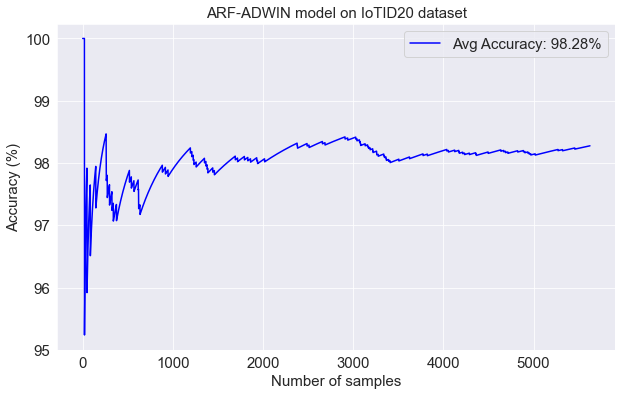

In [36]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 703
Accuracy: 97.65%
Precision: 98.09%
Recall: 99.45%
F1-score: 98.76%
Wall time: 5.26 s


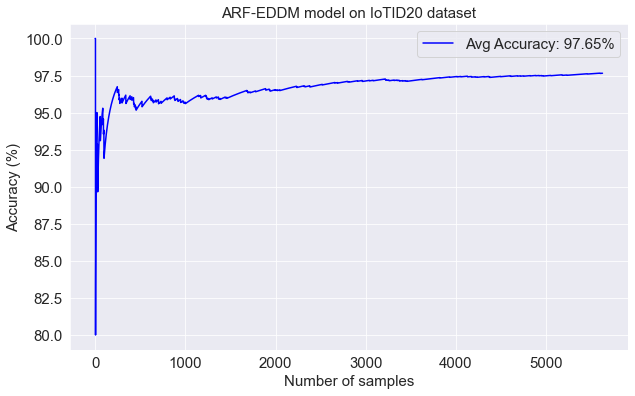

In [37]:
%%time
# Use the Adaptive Random Forest (ARF) model with EDDM drift detector
name2 = "ARF-EDDM model"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = EDDM()) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 1149
Accuracy: 98.21%
Precision: 98.50999999999999%
Recall: 99.6%
F1-score: 99.05000000000001%
Wall time: 22.6 s


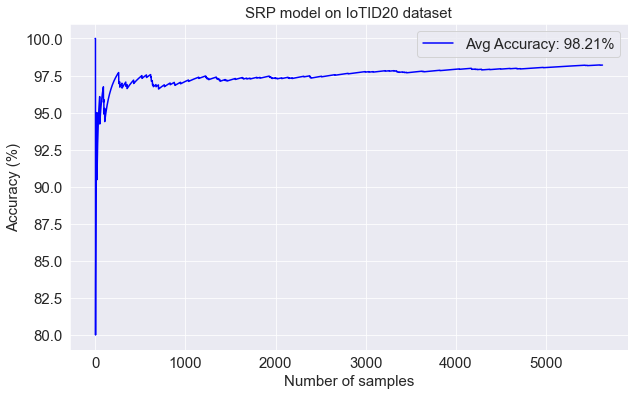

In [34]:
%%time
# Use the Streaming Random Patches (SRP) model
name3 = "SRP model"
model3 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 454
Change detected at index 945
Accuracy: 97.19%
Precision: 97.53%
Recall: 99.55000000000001%
F1-score: 98.53%
Wall time: 2.07 s


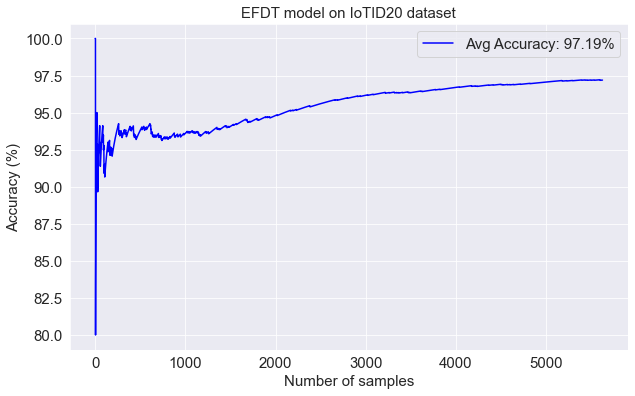

In [38]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model 
name4 = "EFDT model"
model4 = tree.ExtremelyFastDecisionTreeClassifier() # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 486
Change detected at index 884
Change detected at index 1351
Change detected at index 1868
Change detected at index 2140
Change detected at index 2870
Change detected at index 3266
Change detected at index 3979
Change detected at index 4565
Change detected at index 5403
Accuracy: 93.67%
Precision: 95.3%
Recall: 98.13%
F1-score: 96.69%
Wall time: 2.63 s


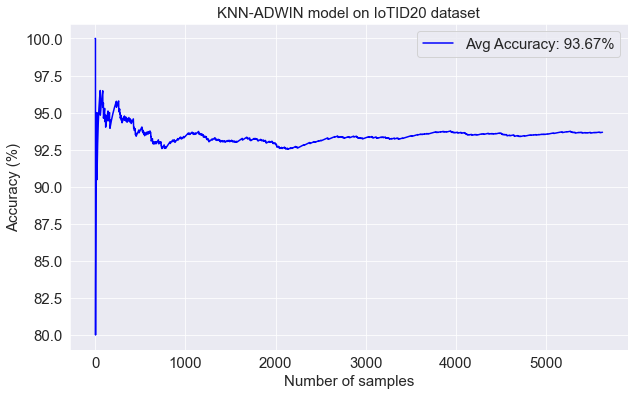

In [18]:
%%time
# Use the K-Nearest Neighbors (KNN) classifier with ADWIN change detector
name5 = "KNN-ADWIN model"
model5 = neighbors.KNNADWINClassifier(window_size=100) # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 519
Change detected at index 798
Change detected at index 1234
Change detected at index 1892
Change detected at index 2968
Change detected at index 3381
Change detected at index 3992
Change detected at index 4528
Accuracy: 93.55%
Precision: 94.96%
Recall: 98.38%
F1-score: 96.64%
Wall time: 15.4 s


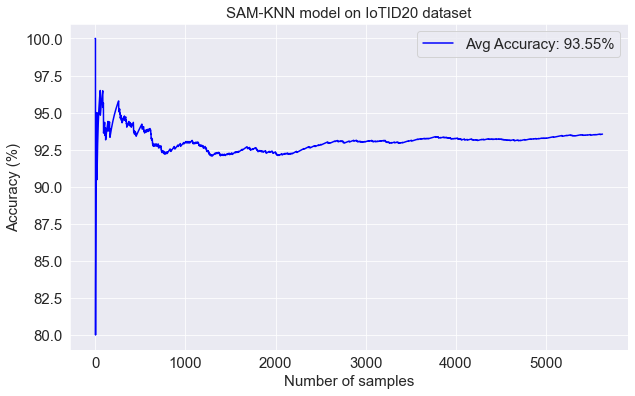

In [19]:
%%time
# Use the Self Adapting Memory (SAM) KNN model 
name6 = "SAM-KNN model"
model6 = neighbors.SAMKNNClassifier(window_size=100) # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 348
Change detected at index 660
Change detected at index 1040
Change detected at index 1333
Change detected at index 1738
Change detected at index 2152
Change detected at index 2746
Change detected at index 3084
Change detected at index 3369
Change detected at index 4126
Change detected at index 4505
Change detected at index 5435
Accuracy: 91.79%
Precision: 95.99%
Recall: 95.27%
F1-score: 95.63000000000001%
Wall time: 704 ms


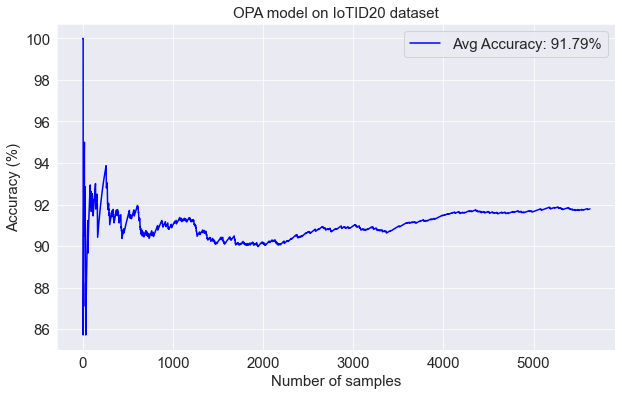

In [20]:
%%time
# Use the Online Passive-Aggressive (OPA) model
name7 = "OPA model"
model7 = linear_model.PAClassifier() # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m7, name7) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 519
Change detected at index 947
Accuracy: 97.67%
Precision: 98.00999999999999%
Recall: 99.55000000000001%
F1-score: 98.77%
Wall time: 28.5 s


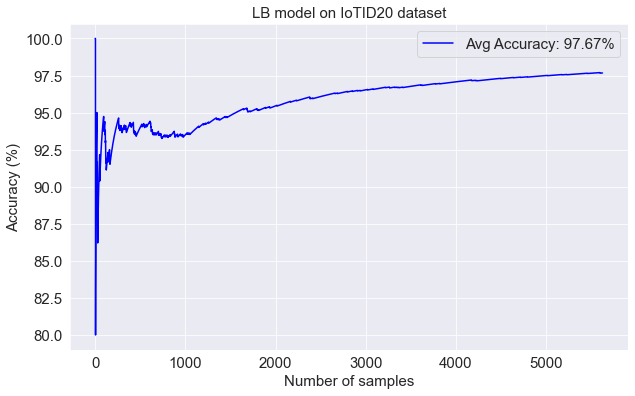

In [33]:
%%time
# Use the Leveraging Bagging (LB) model 
name8 = "LB model"
model8 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m8 = adaptive_learning(model8, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m8, name8) # Draw the figure of how the real-time accuracy changes with the number of samples

In [22]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
# proposed in our previous work: https://github.com/Western-OC2-Lab/PWPAE-Concept-Drift-Detection-and-Adaptation
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=2) # SRP-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=2,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM

    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=15)
    # Initial FS
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1) 
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1) 
        
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        # Calculate the real-time error rates of four base learners
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

Accuracy: 98.4%
Precision: 98.6%
Recall: 99.72%
F1-score: 99.16%
Wall time: 28.8 s


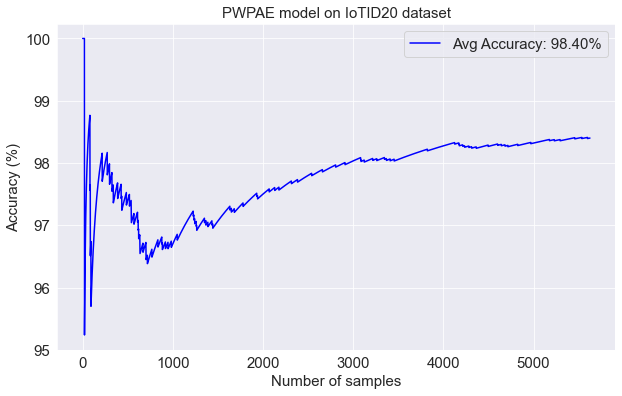

In [23]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name9 = "PWPAE model"
t, m9 = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m9, name9) # Draw the figure of how the real-time accuracy changes with the number of samples

# 4. Proposed Multi-Stage Automated Network Analytics (MSANA) Framework
Main Module 1: Drift-based Dynamic Feature Selection  
Main Module 2: Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)

In [40]:
# Define the Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE) model
# An extension method of the PWPAE model
def MSANA(model1, model2, model3, model4, X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()
    
    metric_w1 = []
    metric_w2 = []
    metric_w3 = []
    metric_w4 = []


    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = model1
    hat2 = model2
    hat3 = model3
    hat4 = model4
    
    # Define the two feature selections methods: Variance Threshold and Select-K-Best
    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)
    
    # Use EDDM to detect concept drift, it can be replaced with other drift detection methods like ADWIN, DDM, etc.
    eddm = EDDM()
    drift = 0

    # Initial feature selection on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1) 
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1) 
        
    # Train the online models on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learners predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        if y_pred1 == yi:
            metric_w1.append(0)
        else:
            metric_w1.append(1)
        if y_pred2 == yi:
            metric_w2.append(0)
        else:
            metric_w2.append(1)
        if y_pred3 == yi:
            metric_w3.append(0)
        else:
            metric_w3.append(1)
        if y_pred4 == yi:
            metric_w4.append(0)
        else:
            metric_w4.append(1)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        
        # Calculate the real-time window error rates of four base learners
        if i<1000:
            e1 = 0
            e2 = 0
            e3 = 0
            e4 = 0
        else:        
            e1 = sum(metric_w1[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e2 = sum(metric_w2[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e3 = sum(metric_w3[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e4 = sum(metric_w4[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        
        # Calculate the weight of each base learner by the reciprocal of its window real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41
        
#         print(str(i)+" "+str(w1)+" "+str(w2)+" "+str(w3)+" "+str(w4)+" "+str(y_prob_0)+" "+str(y_prob_1))

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)
        
        # Detect concept drift
        val = 0
        if yi != y_pred:
            val = 1 
        in_drift, in_warning = eddm.update(float(val))
        
        if in_drift & (i>1000) :
            print(f"Change detected at index {i}")
            drift = 1 # indicating that a drift occurs
        
        # If a drift is detected
        if drift == 1: 
            x_new = X_test[round(0.9*i):i]
            y_new = y_test[round(0.9*i):i]
            
            # Relearn the online models on the most recent window data (representing new concept data)
            hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
            hat2 = neighbors.KNNADWINClassifier(window_size=100)
            hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
            hat4 = linear_model.PAClassifier() # SRP-DDM
            
            # Re-select features
            selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
            selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)
            
            for xj, yj in stream.iter_pandas(x_new, y_new):
                selector1 = selector1.learn_one(xj)
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                selector2 = selector2.learn_one(xj, yj)      
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                xa = selector2.transform_one(xj)
                hat1.learn_one(xa,yj)
                hat2.learn_one(xa,yj)
                hat3.learn_one(xa,yj)
                hat4.learn_one(xa,yj)
                
                if j ==1:
                    print(len(xa))
                    j=0
            drift = 0   
        
        j=1
        

        t.append(i)
        m.append(metric.get()*100)
        
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    
    # outputs
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    print(metric1.get()*100)
    print(metric2.get()*100)
    print(metric3.get()*100)
    print(metric4.get()*100)
    return t, m

Accuracy: 98.6%
Precision: 98.55000000000001%
Recall: 99.98%
F1-score: 99.26%
97.72525324329128
98.98702683490315
97.88519637462235
97.19210947218767
Wall time: 17.8 s


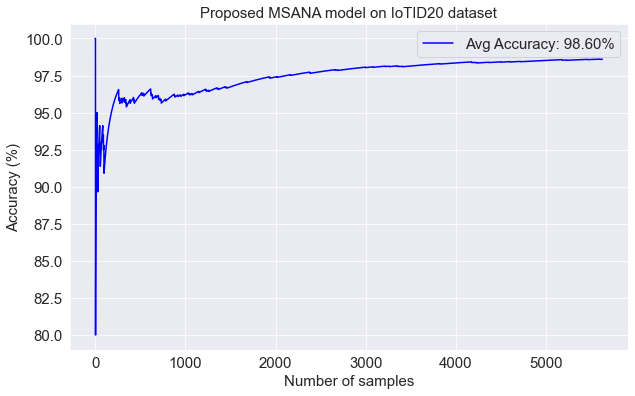

In [41]:
%%time
# Use the proposed Multi-Stage Automated Network Analytics (MSANA) model 

# Select the four base online models, they can be changed based on the performance of the models
bm1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
bm2 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
bm3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
bm4 = tree.ExtremelyFastDecisionTreeClassifier() # EFDT

name = "Proposed MSANA model"
t, m = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

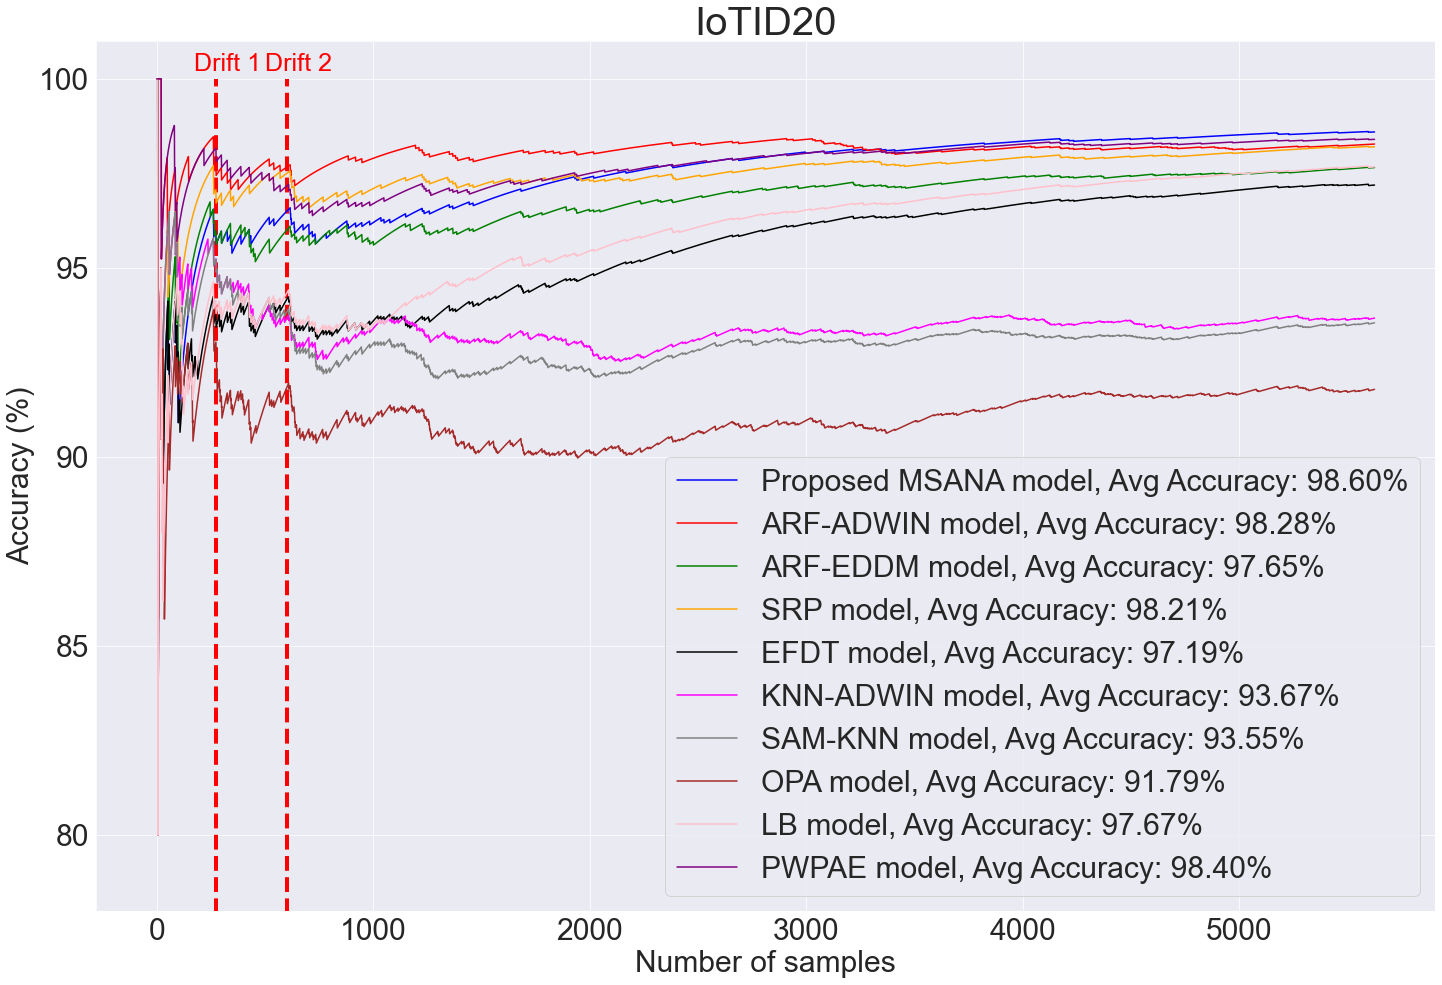

In [42]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,16)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
# plt.plot(t,m0,'pink',label=name0+', Avg Accuracy: %.2f%%'%(m0[-1]))
plt.plot(t,m1,'-r',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))
plt.plot(t,m8,'pink',label=name8+', Avg Accuracy: %.2f%%'%(m8[-1]))
plt.plot(t,m9,'purple',label=name9+', Avg Accuracy: %.2f%%'%(m9[-1]))

# Draw the drift points/time
dr = [0,270,600]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-100, 100.2, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(78, 101)
plt.title('IoTID20', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()

The performance of the proposed MSANA model outperforms other models. Please note that the results might be different when using different datasets or different subsets of the IoTID20 dataset.

Accuracy: 98.81%
Precision: 98.92999999999999%
Recall: 99.81%
F1-score: 99.37%
98.48942598187311
98.7737693264617
97.08548071796695
96.90776612759907
Wall time: 18.9 s


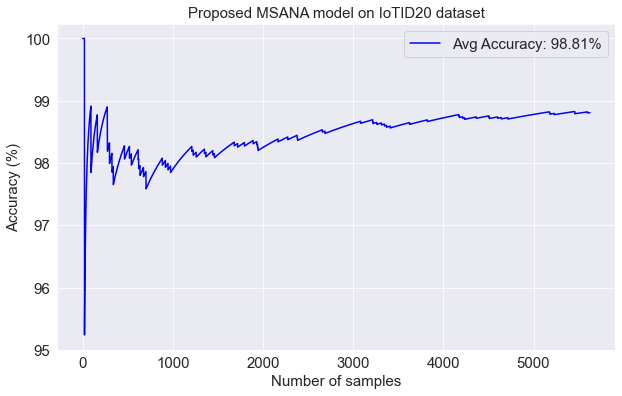

In [43]:
%%time
# Example: combine the ensemble model with dynamic data balancing methods.

bm1 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3),
                                 desired_dist={0: .1, 1: .9},
                                seed=42
                                ) # ARF-ADWIN
bm2 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()),
                                 desired_dist={0: .1, 1: .9},
                                seed=42
                                ) # ARF-ADWIN
bm3 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()), 
                                 desired_dist={0: .1, 1: .9},
                                seed=42
                                ) # ARF-ADWIN
bm4 = imblearn.RandomOverSampler(tree.ExtremelyFastDecisionTreeClassifier(),
                                 desired_dist={0: .1, 1: .9},
                                seed=42
                                ) # ARF-ADWIN

name = "Proposed MSANA model"
t, m = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

The accuracy improved from 98.6% to 98.81% after adding dynamic data balancing

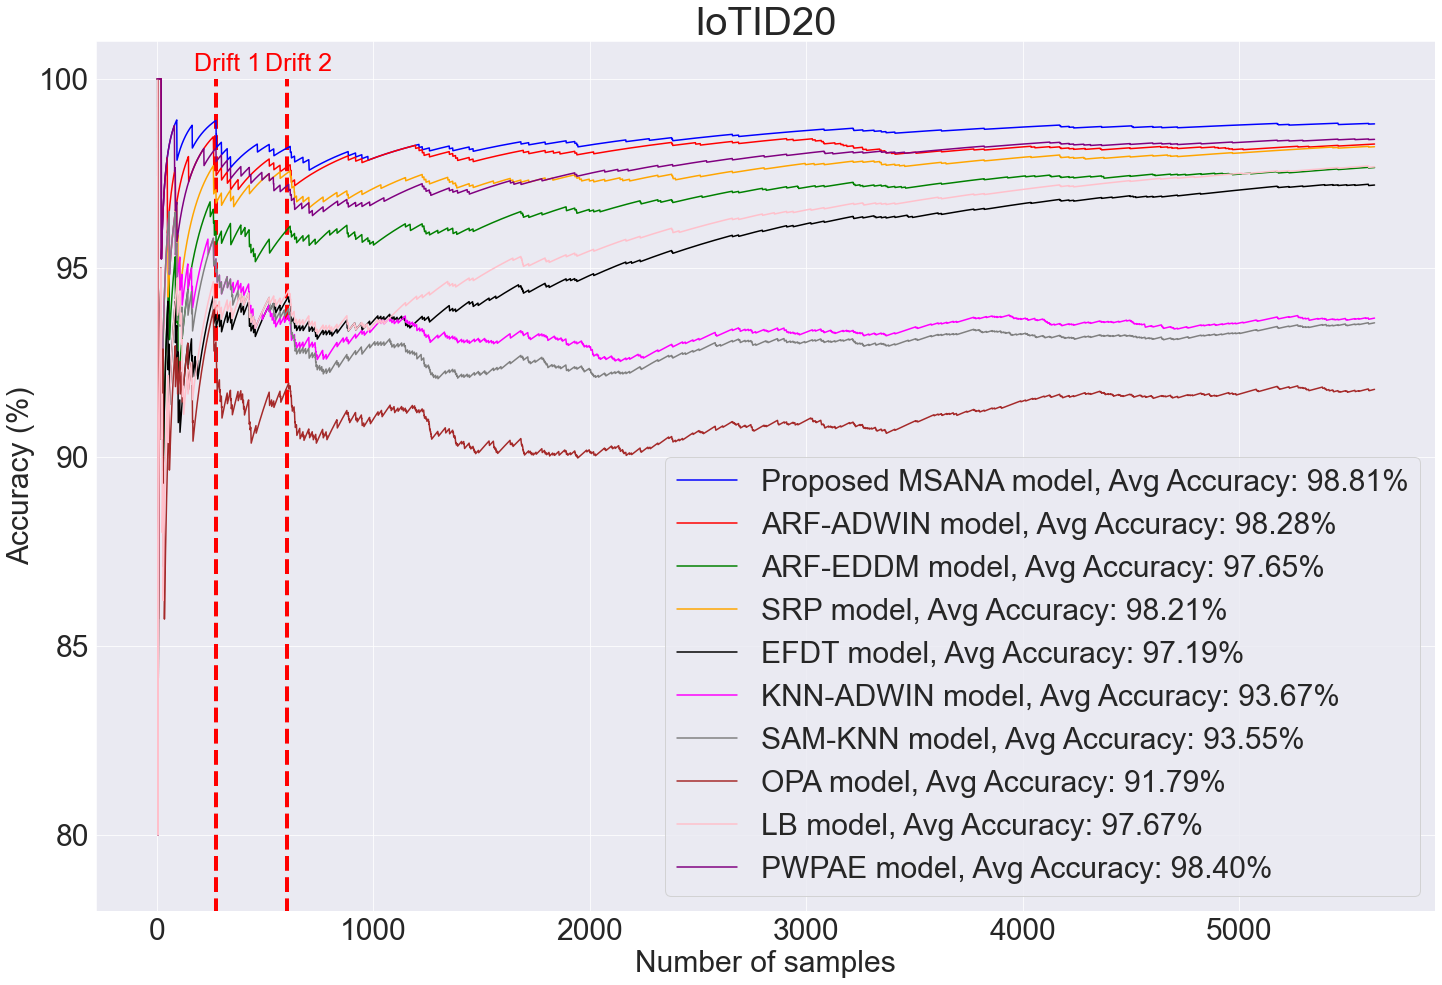

In [44]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,16)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
# plt.plot(t,m0,'pink',label=name0+', Avg Accuracy: %.2f%%'%(m0[-1]))
plt.plot(t,m1,'-r',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))
plt.plot(t,m8,'pink',label=name8+', Avg Accuracy: %.2f%%'%(m8[-1]))
plt.plot(t,m9,'purple',label=name9+', Avg Accuracy: %.2f%%'%(m9[-1]))

# Draw the drift points/time
dr = [0,270,600]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-100, 100.2, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(78, 101)
plt.title('IoTID20', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()